In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import seaborn as sns
from pickle import load
from pickle import dump

In [2]:
def print_scores(y, y_pred, model):
    print(
        'Accuracy score: {:.02%}, Precision: {:.02%}, Recall: {:.02%}, F1 score: {:.02%} '.format(
            accuracy_score(y, y_pred),
            precision_score(y, y_pred, pos_label=1),
            recall_score(y, y_pred, pos_label=1),
            f1_score(y, y_pred, pos_label=1)
        ), model
    )

# Data understanding

In [3]:
# Importing the dataset
normal = pd.read_csv('Datasets/bearings/NB.csv')
normal['Fault'] = 1
print('Size of normal data: ',normal.shape)

abnormal = pd.read_csv('Datasets/bearings/IR - 7.csv')
abnormal['Fault'] = -1
print('Size of abnormal data: ',abnormal.shape)

Size of normal data:  (121155, 3)
Size of abnormal data:  (121155, 3)


In [4]:
normal.head()

,DE,FE,Fault
0,0.064254,0.038625,1
1,0.063002,0.096769,1
2,-0.004381,0.127382,1
3,-0.035882,0.144640,1
4,-0.023991,0.086702,1


In [5]:
abnormal.head()

,DE,FE,Fault
0,-0.093238,-0.029175,-1
1,0.187288,-0.186347,-1
2,0.217663,-0.341260,-1
3,0.070172,-0.160871,-1
4,0.100385,0.179978,-1


In [6]:
# combine normal and abnormal data and reset index for later use
dataset = normal.append(abnormal)
dataset = dataset.reset_index(drop=True)
dataset

,DE,FE,Fault
0,0.064254,0.038625,1
1,0.063002,0.096769,1
2,-0.004381,0.127382,1
3,-0.035882,0.144640,1
4,-0.023991,0.086702,1
...,...,...,...
242305,0.135958,-0.047255,-1
242306,-0.083167,-0.070882,-1
242307,0.391469,-0.181005,-1
242308,0.185501,0.136011,-1


In [7]:
normal = dataset[dataset.Fault == 1]
abnormal = dataset[dataset.Fault == -1]

## check null and duplicates

In [8]:
# Checking for null values
features = ['DE', 'FE', 'Fault']
N_null = sum(dataset[features].isnull().sum())
print("The dataset contains {} null values".format(N_null)) 

# Removing duplicates if there exist
N_dupli = sum(dataset.duplicated(keep='first'))
dataset = dataset.drop_duplicates(keep='first').reset_index(drop=True)
print("The dataset contains {} duplicates".format(N_dupli))

# Number of samples in the dataset
N = dataset.shape[0]
print('Size of cleaned dataset: ', N)

The dataset contains 0 null values
The dataset contains 6941 duplicates
Size of cleaned dataset:  235369


6941 duplicates are removed

## Basic statistics

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235369 entries, 0 to 235368
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   DE      235369 non-null  float64
 1   FE      235369 non-null  float64
 2   Fault   235369 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 5.4 MB


All data type are numetrical, there is no need to encode feature

In [10]:
dataset.describe()

,DE,FE,Fault
count,235369.000000,235369.000000,235369.000000
mean,0.007916,0.033552,-0.025904
std,0.219440,0.173038,0.999667
min,-1.425531,-0.895782,-1.000000
25%,-0.068060,-0.043762,-1.000000
50%,0.010848,0.031640,-1.000000
75%,0.082194,0.109918,1.000000
max,1.639620,0.957213,1.000000


Statistics are visualized as plot later for better understanding

In [11]:
# save table as csv to folder
dataset.describe().to_csv(r'Statistics/anomaly-detection-bearing-statistics.csv', index = True)

## EDA

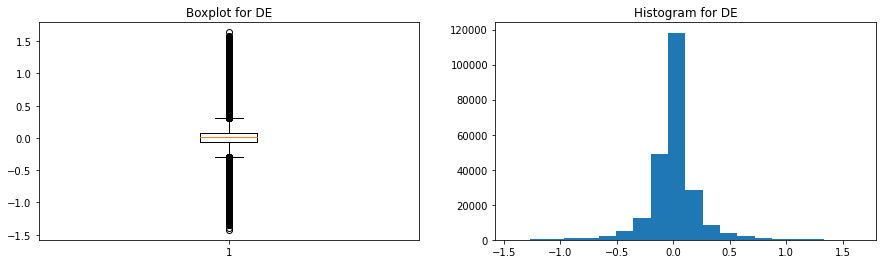

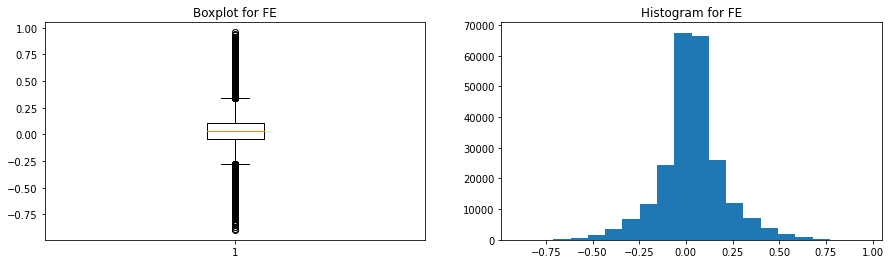

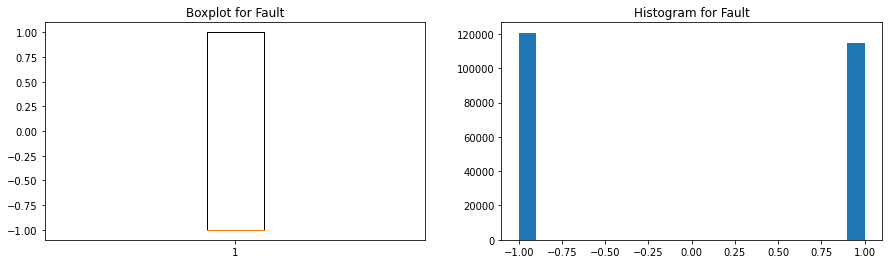

In [12]:
# Boxpot and histogram of each feature
for (columnName, columnData) in dataset.iteritems():

    # Creating an empty chart
    fig, ((ax1, ax2)) = plt.subplots(1, 2,  figsize=(15, 4))

    # Extracting the feature values
    x = columnData

    # Boxplot
    ax1.boxplot(x)
    ax1.set_title( 'Boxplot for {}'.format(columnName) )

    # Histogram
    ax2.hist(x, bins=20)
    ax2.set_title( 'Histogram for {}'.format(columnName) )

    # Display
    plt.show()

In [15]:
def plot_feature(data, dataName):
    x = list(range(len(data.index)))
    y = data

    # plot the humidity data
    fig = plt.figure(figsize=(18, 6))
    plt.plot(x,y)
    plt.ylabel(dataName)
    plt.xlabel('Index')
    plt.xlim((0,len(data.index)))

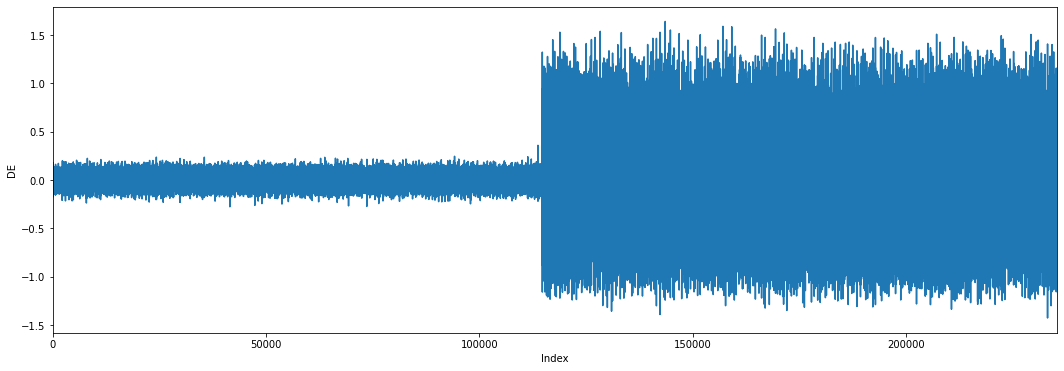

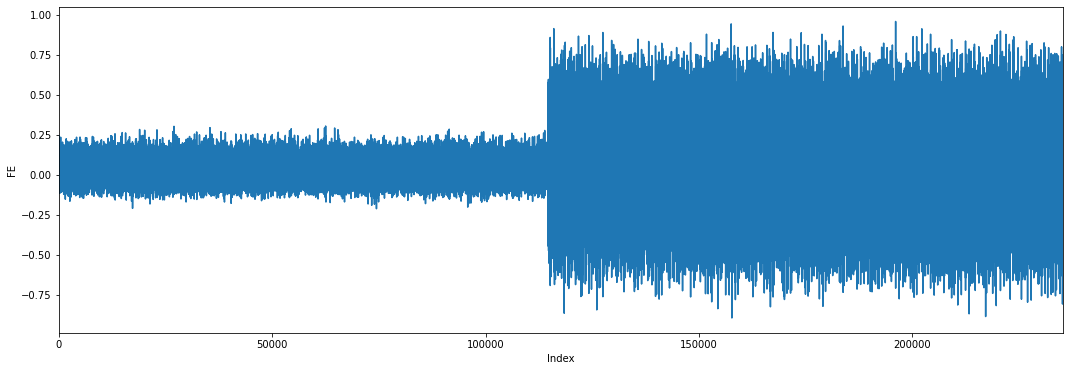

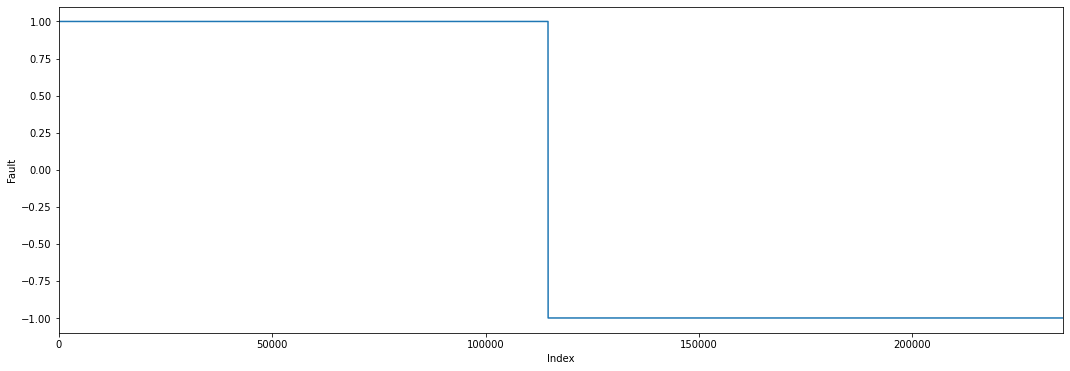

In [16]:
for (columnName, columnData) in dataset.iteritems():
    plot_feature(columnData, columnName)

## Correlation matrix and heatmap

In [17]:
dataset.corr()

,DE,FE,Fault
DE,1.000000,0.088877,0.015778
FE,0.088877,1.000000,-0.002574
Fault,0.015778,-0.002574,1.000000


In [18]:
# save table as csv to folder
dataset.corr().to_csv(r'Statistics/bearing-corr.csv', index = True)

<AxesSubplot:>

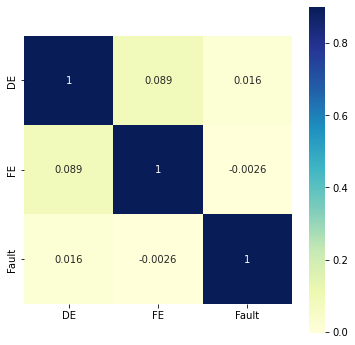

In [19]:
# make correlation matrix to heatmap
f, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(dataset.corr(), cmap='YlGnBu', vmax = .9, square = True, annot=True)

# Data preparation

### Feature scaling and Split data for novelty detection

In [20]:
sc = StandardScaler()
X_inliers = sc.fit_transform(normal[['DE', 'FE']])
X = sc.transform(dataset[['DE', 'FE']])

In [21]:
y = dataset.iloc[:, 2]

In [22]:
X

array([[ 0.82785884,  0.09052428],
       [ 0.80811591,  0.98237156],
       [-0.25471197,  1.45193072],
       ...,
       [ 5.98902043, -3.27832642],
       [ 2.74029281,  1.58428968],
       [-8.11271204, -2.23836316]])

In [23]:
y

0         1
1         1
2         1
3         1
4         1
         ..
235364   -1
235365   -1
235366   -1
235367   -1
235368   -1
Name: Fault, Length: 235369, dtype: int64

In [24]:
X_inliers

array([[ 0.82785884,  0.09052428],
       [ 0.80811591,  0.98237156],
       [-0.25471197,  1.45193072],
       ...,
       [-0.62653722, -1.0376783 ],
       [-0.34355516, -1.2078541 ],
       [-0.36658859, -0.08280293]])

In [25]:
# pickle data for later use
dump(X, open("pickle/dataset/bearing-anomaly-detection/X.pkl", "wb"))
dump(y, open("pickle/dataset/bearing-anomaly-detection/y.pkl", "wb"))
dump(X_inliers, open('pickle/dataset/bearing-anomaly-detection/X_inliers.pkl', 'wb'))

### Feature scaling and Split data for outliers detection

In [39]:
X_train, X_test = train_test_split(normal, test_size = 0.2, shuffle=False, random_state = 0)
y_train, y_test = train_test_split(abnormal, test_size = 0.2, shuffle=False, random_state = 0)

In [40]:
train = X_train.append(y_train)
train = train.reset_index(drop=True)
train

,DE,FE,Fault
0,0.064254,0.038625,1
1,0.063002,0.096769,1
2,-0.004381,0.127382,1
3,-0.035882,0.144640,1
4,-0.023991,0.086702,1
...,...,...,...
193843,0.138557,-0.357080,-1
193844,0.210678,-0.204016,-1
193845,0.126537,-0.303867,-1
193846,-0.186476,-0.246956,-1


In [41]:
test = X_test.append(y_test)
test = test.reset_index(drop=True)
test

,DE,FE,Fault
0,0.058204,-0.015204,1
1,0.011057,0.005958,1
2,-0.066548,0.066362,1
3,-0.131845,0.110535,1
4,-0.132471,0.096153,1
...,...,...,...
48457,0.135958,-0.047255,-1
48458,-0.083167,-0.070882,-1
48459,0.391469,-0.181005,-1
48460,0.185501,0.136011,-1


In [42]:
# pickle data for later use
dump(train, open("pickle/dataset/bearing-anomaly-detection/train.pkl", "wb"))
dump(test, open("pickle/dataset/bearing-anomaly-detection/test.pkl", "wb"))

In [43]:
sc = StandardScaler()
train_data = sc.fit_transform(train[['DE', 'FE']])
test_data = sc.transform(test[['DE', 'FE']])

In [45]:
dump(train_data, open("pickle/dataset/bearing-anomaly-detection/train_data.pkl", "wb"))
dump(test_data, open("pickle/dataset/bearing-anomaly-detection/test_data.pkl", "wb"))

# Novelty detection

train with normal and test with mix => novelty detection

## LOF, novelty detection

In [30]:
# load data
X = load(open('pickle/dataset/bearing-anomaly-detection/X.pkl', 'rb'))
X_inliers = load(open('pickle/dataset/bearing-anomaly-detection/X_inliers.pkl', 'rb'))
y = load(open('pickle/dataset/bearing-anomaly-detection/y.pkl', 'rb'))

In [31]:
lof = LocalOutlierFactor(n_neighbors=50,novelty=True)
lof.fit(X_inliers) 
dataset['pred_anomaly'] = lof.predict(X)

In [32]:
dataset

,DE,FE,Fault,pred_anomaly
0,0.064254,0.038625,1,1
1,0.063002,0.096769,1,1
2,-0.004381,0.127382,1,1
3,-0.035882,0.144640,1,1
4,-0.023991,0.086702,1,1
...,...,...,...,...
235364,0.135958,-0.047255,-1,1
235365,-0.083167,-0.070882,-1,1
235366,0.391469,-0.181005,-1,-1
235367,0.185501,0.136011,-1,1


In [33]:
print_scores(y, dataset['pred_anomaly'], lof)

Accuracy score: 79.72%, Precision: 70.64%, Recall: 99.90%, F1 score: 82.76%  LocalOutlierFactor(n_neighbors=50, novelty=True)


In [34]:
pred_anomalies = dataset[dataset['pred_anomaly'] == -1]

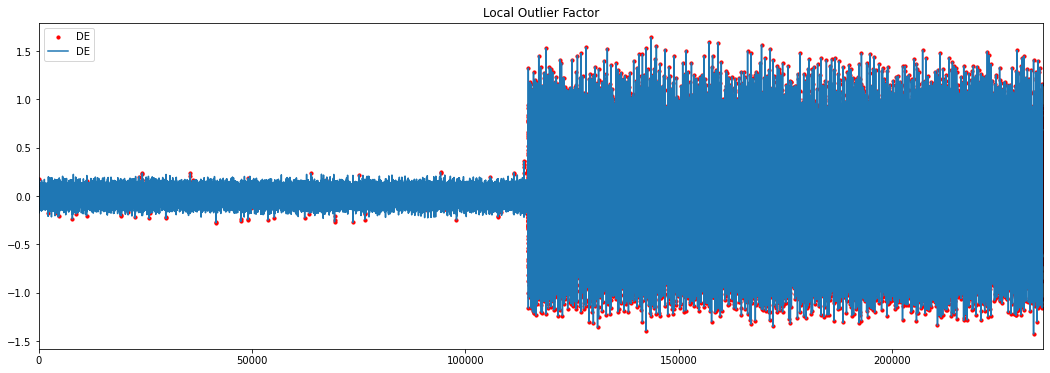

In [35]:
f, (ax1) = plt.subplots(figsize=(18, 6))
ax1.scatter(pred_anomalies.index, pred_anomalies.DE, label='DE', color='red', s=10)
ax1.plot(dataset.index, dataset.DE, label='DE');
plt.xlim((0,len(dataset.index)))

plt.title('Local Outlier Factor')
plt.legend();
plt.show();

# Outliers detection

Outliers detection train with both inliers and outliers

## Isolation forest

In [46]:
# load data
train = load(open('pickle/dataset/bearing-anomaly-detection/train.pkl', 'rb'))
test = load(open('pickle/dataset/bearing-anomaly-detection/test.pkl', 'rb'))
train_data = load(open('pickle/dataset/bearing-anomaly-detection/train_data.pkl', 'rb'))
test_data = load(open('pickle/dataset/bearing-anomaly-detection/test_data.pkl', 'rb'))

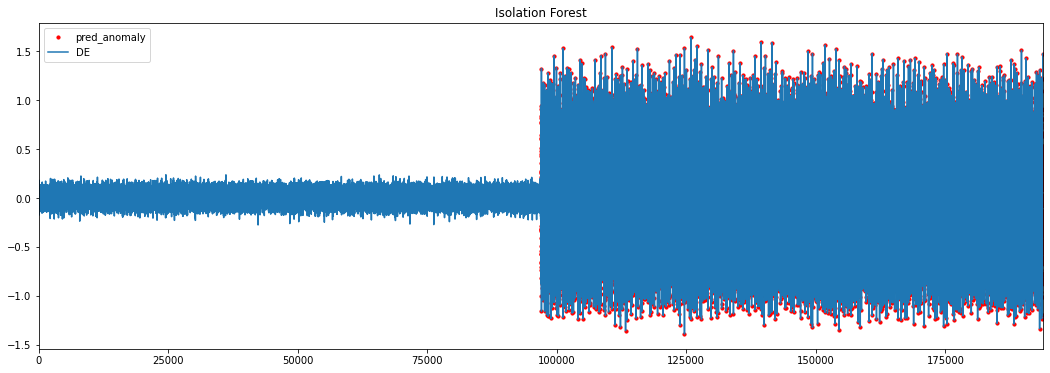

In [47]:
isolationForest =  IsolationForest()
isolationForest.fit(train_data) 
train['pred_anomaly'] = isolationForest.predict(train_data)

# visualization
train_anomalies = train[train['pred_anomaly'] == -1]

f, (ax1) = plt.subplots(figsize=(18, 6))
ax1.scatter(train_anomalies.index, train_anomalies.DE, label='pred_anomaly', color='red', s=10)
ax1.plot(train.index, train.DE, label='DE');
plt.xlim((0,len(train.index)))

plt.title('Isolation Forest')
plt.legend();
plt.show();

print training scores

In [48]:
print_scores(train['Fault'], train['pred_anomaly'], isolationForest)

Accuracy score: 67.24%, Precision: 60.42%, Recall: 100.00%, F1 score: 75.33%  IsolationForest()


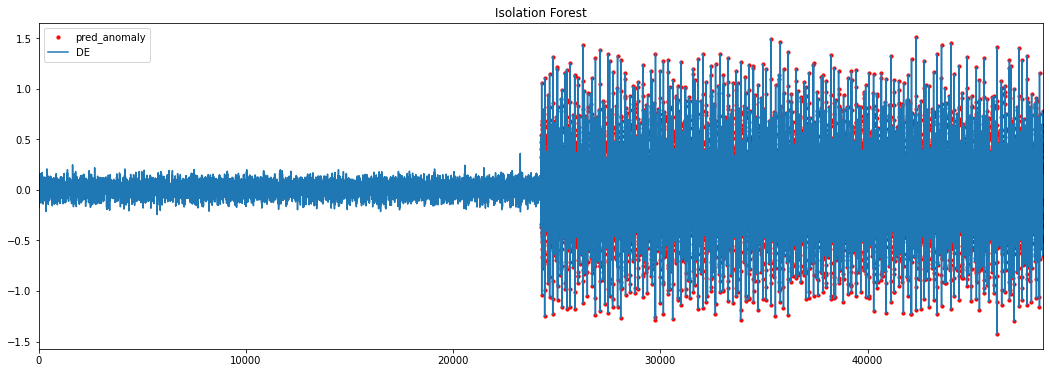

In [49]:
test['pred_anomaly'] = isolationForest.predict(test_data)

# visualization
test_anomalies = test[test['pred_anomaly'] == -1]

f, (ax1) = plt.subplots(figsize=(18, 6))
ax1.scatter(test_anomalies.index, test_anomalies.DE, label='pred_anomaly', color='red', s=10)
ax1.plot(test.index, test.DE, label='DE');
plt.xlim((0,len(test.index)))

plt.title('Isolation Forest')
plt.legend();
plt.show();

In [50]:
print_scores(test['Fault'], test['pred_anomaly'] , isolationForest)

Accuracy score: 67.42%, Precision: 60.54%, Recall: 100.00%, F1 score: 75.42%  IsolationForest()


## Elliptic Envelope

In [51]:
# load data
train = load(open('pickle/dataset/bearing-anomaly-detection/train.pkl', 'rb'))
test = load(open('pickle/dataset/bearing-anomaly-detection/test.pkl', 'rb'))
train_data = load(open('pickle/dataset/bearing-anomaly-detection/train_data.pkl', 'rb'))
test_data = load(open('pickle/dataset/bearing-anomaly-detection/test_data.pkl', 'rb'))

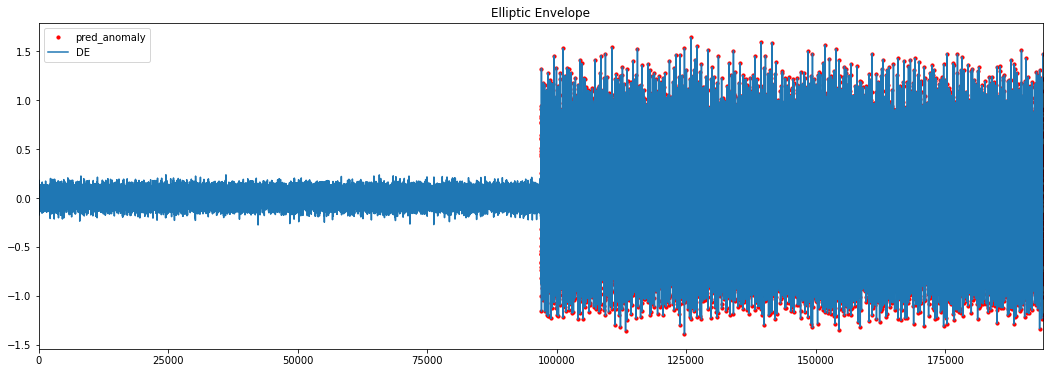

In [52]:
# Elliptic Envelope
ee =  EllipticEnvelope(random_state=0)
train['pred_anomaly'] = ee.fit_predict(train_data)
# visualization
train_anomalies = train[train['pred_anomaly'] == -1]

f, (ax1) = plt.subplots(figsize=(18, 6))
ax1.scatter(train_anomalies.index, train_anomalies.DE, label='pred_anomaly', color='red', s=10)
ax1.plot(train.index, train.DE, label='DE');
plt.xlim((0,len(train.index)))

plt.title('Elliptic Envelope')
plt.legend();
plt.show();

### print training scores

In [53]:
print_scores(train['Fault'], train['pred_anomaly'], ee)

Accuracy score: 60.00%, Precision: 55.56%, Recall: 100.00%, F1 score: 71.43%  EllipticEnvelope(random_state=0)


### Predict on testing data

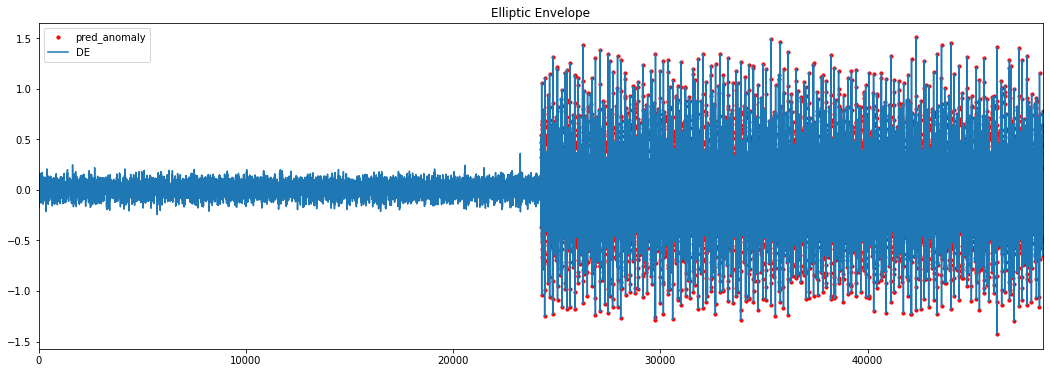

In [54]:
test['pred_anomaly'] = ee.predict(test_data)

# visualization
test_anomalies = test[test['pred_anomaly'] == -1]

f, (ax1) = plt.subplots(figsize=(18, 6))
ax1.scatter(test_anomalies.index, test_anomalies.DE, label='pred_anomaly', color='red', s=10)
ax1.plot(test.index, test.DE, label='DE');
plt.xlim(0, len(test.index))

plt.title('Elliptic Envelope')
plt.legend();
plt.show();

### Print the testing scores

In [55]:
print_scores(test['Fault'], test['pred_anomaly'], ee)

Accuracy score: 60.32%, Precision: 55.75%, Recall: 100.00%, F1 score: 71.59%  EllipticEnvelope(random_state=0)


## One class SVM

In [62]:
# load data
train = load(open('pickle/dataset/bearing-anomaly-detection/train.pkl', 'rb'))
test = load(open('pickle/dataset/bearing-anomaly-detection/test.pkl', 'rb'))
train_data = load(open('pickle/dataset/bearing-anomaly-detection/train_data.pkl', 'rb'))
test_data = load(open('pickle/dataset/bearing-anomaly-detection/test_data.pkl', 'rb'))

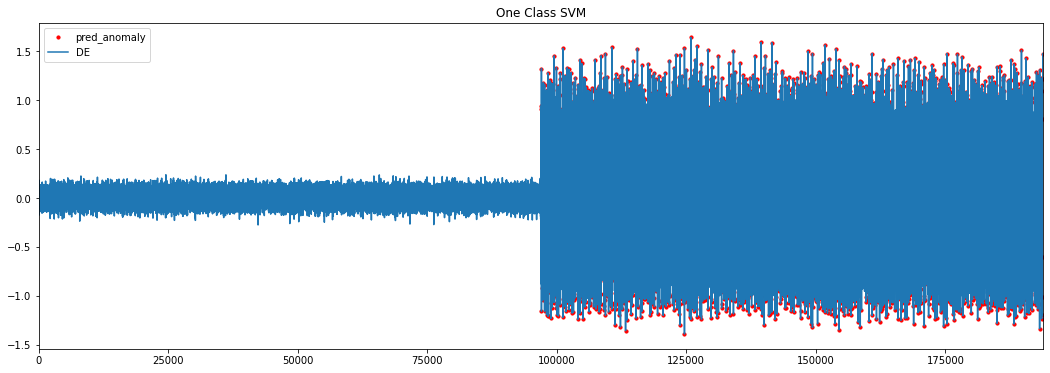

In [63]:
svm = OneClassSVM(nu = 0.01,kernel="rbf", gamma=0.01)
pred_train = svm.fit(train_data)
train['pred_anomaly'] = pd.Series(svm.predict(train_data))

train_anomalies = train[train['pred_anomaly'] == -1]

f, (ax3) = plt.subplots(figsize=(18, 6))
ax3.scatter(train_anomalies.index, train_anomalies.DE, label='pred_anomaly', color='red', s=10)
ax3.plot(train.index, train.DE, label='DE');
plt.xlim((0,len(train.index)))

plt.title('One Class SVM')
plt.legend();
plt.show();

### Print training scores

In [64]:
print_scores(train['Fault'], train['pred_anomaly'], svm)

Accuracy score: 51.00%, Precision: 50.50%, Recall: 100.00%, F1 score: 67.11%  OneClassSVM(gamma=0.01, nu=0.01)


### Predict on test data

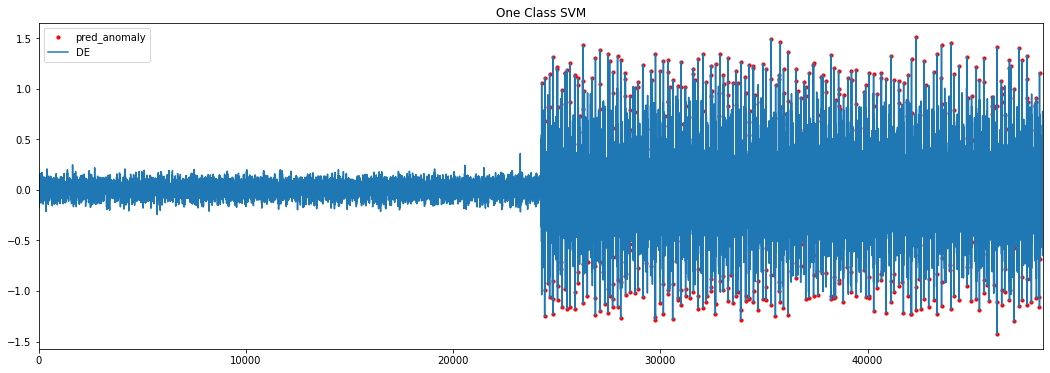

In [65]:
test['pred_anomaly'] = svm.predict(test_data)

test_anomalies = test[test['pred_anomaly'] == -1]

f, (ax3) = plt.subplots(figsize=(18, 6))
ax3.scatter(test_anomalies.index, test_anomalies.DE, label='pred_anomaly', color='red', s=10)
ax3.plot(test.index, test.DE, label='DE');
plt.xlim(0, len(test.index))

plt.title('One Class SVM')
plt.legend();
plt.show();

In [66]:
print_scores(test['Fault'], test['pred_anomaly'], svm)

Accuracy score: 51.02%, Precision: 50.51%, Recall: 100.00%, F1 score: 67.12%  OneClassSVM(gamma=0.01, nu=0.01)


### Try default nu

In [67]:
# load data
train = load(open('/Users/yi-chenlin/Desktop/Final project/pickle/dataset/bearing/train.pkl', 'rb'))
test = load(open('/Users/yi-chenlin/Desktop/Final project/pickle/dataset/bearing/test.pkl', 'rb'))
train_data = load(open('/Users/yi-chenlin/Desktop/Final project/pickle/dataset/bearing/train_data.pkl', 'rb'))
test_data = load(open('/Users/yi-chenlin/Desktop/Final project/pickle/dataset/bearing/test_data.pkl', 'rb'))

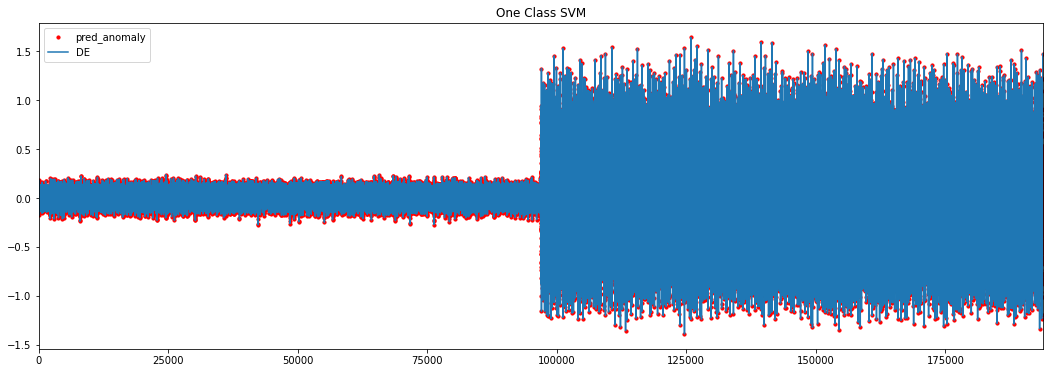

In [68]:
svm = OneClassSVM(kernel="rbf", gamma=0.01)
pred_train = svm.fit(train_data)
train['pred_anomaly'] = pd.Series(svm.predict(train_data))

train_anomalies = train[train['pred_anomaly'] == -1]

f, (ax3) = plt.subplots(figsize=(18, 6))
ax3.scatter(train_anomalies.index, train_anomalies.DE, label='pred_anomaly', color='red', s=10)
ax3.plot(train.index, train.DE, label='DE');
plt.xlim((0,len(train.index)))

plt.title('One Class SVM')
plt.legend();
plt.show();

In [69]:
print_scores(train['Fault'], train['pred_anomaly'], svm)

Accuracy score: 84.83%, Precision: 84.83%, Recall: 84.83%, F1 score: 84.83%  OneClassSVM(gamma=0.01)


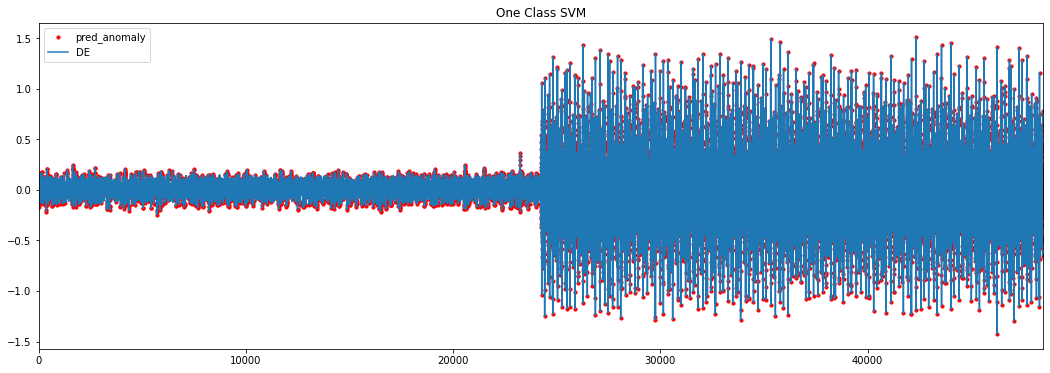

In [70]:
test['pred_anomaly'] = svm.predict(test_data)

test_anomalies = test[test['pred_anomaly'] == -1]

f, (ax3) = plt.subplots(figsize=(18, 6))
ax3.scatter(test_anomalies.index, test_anomalies.DE, label='pred_anomaly', color='red', s=10)
ax3.plot(test.index, test.DE, label='DE');
plt.xlim(0, len(test.index))

plt.title('One Class SVM')
plt.legend();
plt.show();

In [71]:
print_scores(test['Fault'], test['pred_anomaly'], svm)

Accuracy score: 84.51%, Precision: 84.57%, Recall: 84.44%, F1 score: 84.50%  OneClassSVM(gamma=0.01)
